In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from   skopt import gp_minimize

## LOAD DATASETS

In [121]:
sig_df = pd.read_pickle('Pkl_files_sc/Mstop_175_mchi_1.pkl')
tt_df  = pd.read_pickle('DESY_ttbar_sc.pkl')

In [122]:
SUSY_event_w = sig_df['event_w']
tt_event_w   = tt_df['event_w']

In [123]:
selected_columns = ['llbar_dphi', 'llbar_deta','MET' ,
                    'b1k', 'b2k', 'b1r', 'b2r', 'b1n', 'b2n']
                    #'c_kk', 'c_rk', 'c_nk', 'c_kr', 'c_rr', 'c_nr', 'c_kn', 'c_rn', 'c_nn', 'c_hel']
sig_df = sig_df[selected_columns]
tt_df  = tt_df[selected_columns]

In [124]:
sig_df.shape

(60783, 9)

## STANDARDIZE

In [125]:
#sig_mean = sig_df.mean()
#sig_std  = sig_df.std()

#tt_mean  = tt_df.mean()
#tt_std   = tt_df.std()

#sig_df = (sig_df - sig_mean)/ sig_std
#tt_df  = (tt_df  - tt_mean)/ tt_std

In [126]:
#sig_df_train = (sig_df_train - sig_mean)/ sig_std
#tt_df_train  = (tt_df_train  - tt_mean)/ tt_std

#sig_df_val   = (sig_df_val - sig_mean)/ sig_std
#tt_df_val    = (tt_df_val  - tt_mean)/ tt_std

#sig_df_test  = (sig_df_test - sig_mean)/ sig_std
#tt_df_test   = (tt_df_test  - tt_mean)/ tt_std

In [127]:
# Select about half of whichever dataframe is smaller

sig_df_train = sig_df[:25000]
tt_df_train  = tt_df[:25000]

sig_df_val   = sig_df[25000:40000]
tt_df_val    = tt_df[25000:40000]

sig_df_test  = sig_df[40000:]
tt_df_test   = tt_df[40000:]

sig_df_train = (sig_df_train - sig_df_train.mean())/ sig_df_train.std()
tt_df_train  = (tt_df_train  - tt_df_train.mean())/ tt_df_train.std()

sig_df_val  = (sig_df_val - sig_df_val.mean())/ sig_df_val.std()
tt_df_val   = (tt_df_val  - tt_df_val.mean())/ tt_df_val.std()

sig_df_test  = (sig_df_test - sig_df_test.mean())/ sig_df_test.std()
tt_df_test   = (tt_df_test  - tt_df_test.mean())/ tt_df_test.std()

In [128]:
train_signal    = sig_df_train.values
train_bkg       = tt_df_train.values

train_sig_label = np.ones(len(train_signal))
train_bkg_label = np.zeros(len(train_bkg))

train_data      = np.concatenate((train_signal,train_bkg))
train_label     = np.concatenate((train_sig_label,train_bkg_label))

In [129]:
val_signal     = sig_df_val.values
val_bkg        = tt_df_val.values

val_sig_label  = np.ones(len(val_signal))
val_bkg_label  = np.zeros(len(val_bkg))

val_data       = np.concatenate((val_signal,val_bkg))
val_label      = np.concatenate((val_sig_label,val_bkg_label))

In [130]:
test_signal    = sig_df_test.values
test_bkg       = tt_df_test.values

test_sig_label = np.ones(len(test_signal))
test_bkg_label = np.zeros(len(test_bkg))

test_data      = np.concatenate((test_signal,test_bkg))
test_label     = np.concatenate((test_sig_label,test_bkg_label))

In [131]:
#from sklearn.model_selection import StratifiedKFold
#skf = StratifiedKFold(n_splits=2, shuffle=True)
#skf.get_n_splits(data, label)
#skf.split(data, label)

#for train_index, test_index in skf.split(data, label):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #x_train, x_test = data[train_index], data[test_index]
    #y_train, y_test = label[train_index], label[test_index]

## DEFINE THE MODEL

In [132]:
from keras.models       import Sequential
from keras.layers       import Dense, Activation, Dropout
from keras.optimizers   import SGD
from keras.regularizers import l1, l2
from keras.callbacks    import EarlyStopping
from keras.callbacks    import ModelCheckpoint

In [145]:
model = Sequential()
model.add(Dense(81,  input_dim = 9, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(100, input_dim = 100, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#bias_regularizer=l2(0.01)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 81)                810       
_________________________________________________________________
dropout_21 (Dropout)         (None, 81)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 82        
Total params: 892
Trainable params: 892
Non-trainable params: 0
_________________________________________________________________


In [146]:
shuffler    = np.random.permutation(len(train_label))
train_data  = train_data[shuffler]
train_label = train_label[shuffler]

In [147]:
y_red = train_label[-10000:]
print(len(y_red[y_red == 0]))
print(len(y_red[y_red == 1]))

4969
5031


In [148]:
# hist = model.fit(train_data, train_label, batch_size=128, epochs=100,verbose=1, shuffle=True, validation_split=0.2,
#                   callbacks=[EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min'),
#                   ModelCheckpoint(filepath='model.h5', verbose=0)])

In [149]:
shuffler  = np.random.permutation(len(val_label))
val_data  = val_data[shuffler]
val_label = val_label[shuffler]

In [150]:
hist = model.fit(train_data, train_label, batch_size=32, epochs=50,verbose=1, shuffle=True, validation_data=(val_data, val_label),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1529/1563 [============================>.] - ETA: 0s - loss: 0.3350 - accuracy: 0.9081WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14bdbe940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

## PLOT LOSSES AND ACCURACY

In [27]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'accuracy' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['accuracy'][-1])
            do_acc = True
        if 'val_accuracy' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_accuracy'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Accuracy' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Accuracy by Epoch', fontsize=17)
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'accuracy' in loss.history:
            plt.plot(loss.history['accuracy'], lw=2, label=label+" accuracy", color=color)
        if 'val_accuracy' in loss.history:
            plt.plot(loss.history['val_accuracy'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(fontsize=17)
    plt.show()

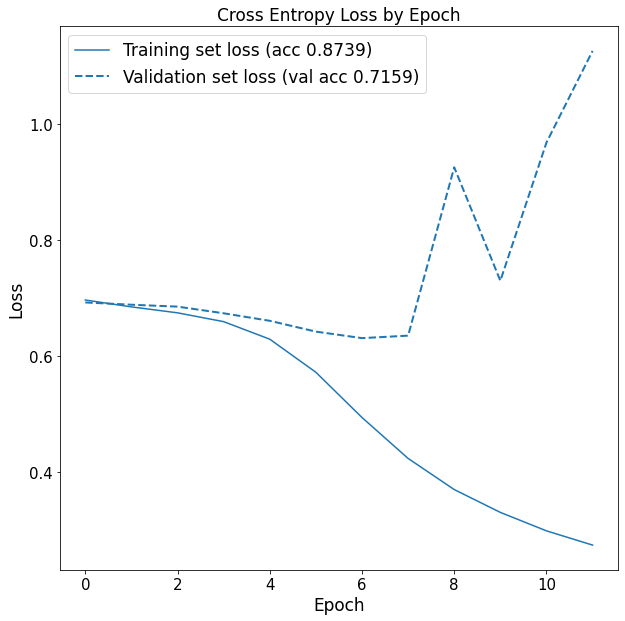

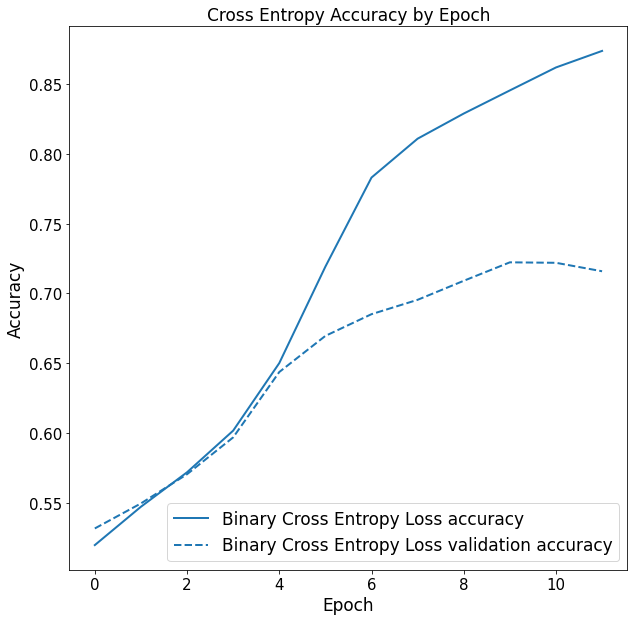

In [197]:
show_losses( [("Binary Cross Entropy Loss", hist)])

## EXAMINE OUTPUTS

In [111]:
tt_pred  = model.predict(tt_df_test) 
si_pred  = model.predict(sig_df_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [112]:
SUSY_lumi_w = SUSY_event_w[40000:]
tt_lumi_w   = tt_event_w[40000:]

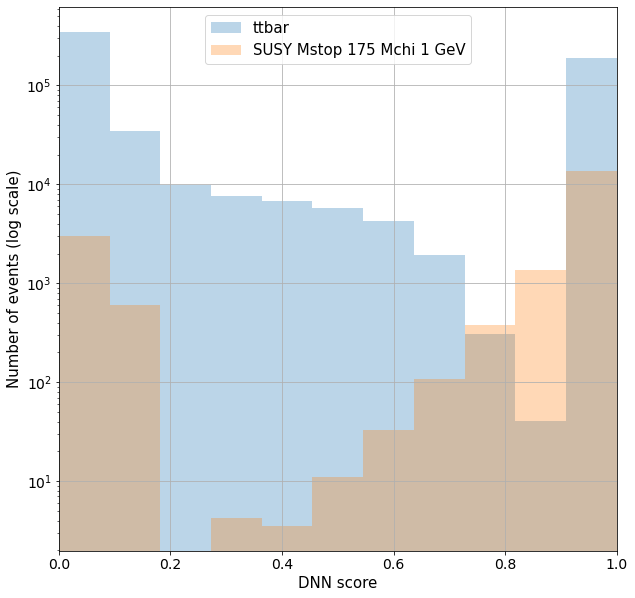

In [113]:
binning = np.linspace(0, 1, 12)
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(tt_pred, bins=binning, alpha=0.3, label='ttbar'   , weights=tt_lumi_w)
plt.hist(si_pred, bins=binning, alpha=0.3, label='SUSY Mstop 175 Mchi 1 GeV', weights=SUSY_lumi_w)
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('DNN score Mstop_235 Mchi_60.jpg')

## METRICS

In [63]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

y_pred_val = model.predict(val_data).ravel()
y_pred_test  = model.predict(test_data).ravel()

fpr_keras_val, tpr_keras_val, thresholds_keras = roc_curve(val_label, y_pred_val)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(test_label , y_pred_test)

auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_val = auc(fpr_keras_val, tpr_keras_val)

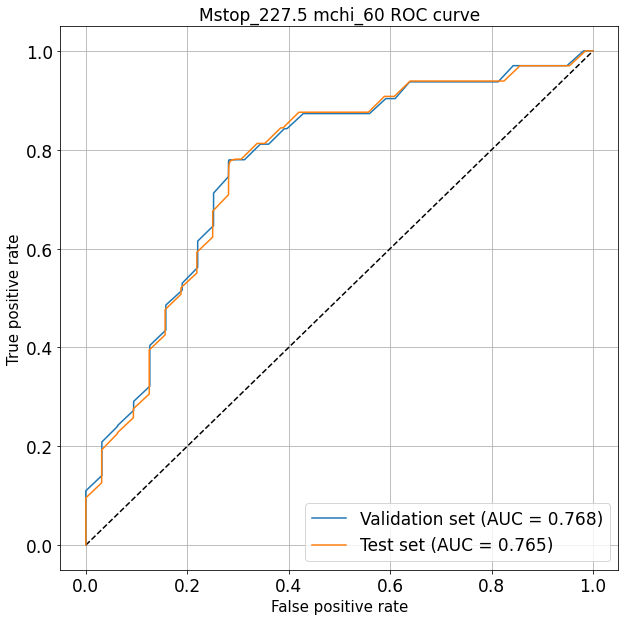

In [66]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_val, tpr_keras_val, label='Validation set (AUC = {:.3f})'.format(auc_keras_val))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_227.5 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
#plt.savefig('ROC Mstop 227.5 Mchi 60.jpg')
plt.show()

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_label,np.round(y_pred_test)))
print(classification_report(test_label,np.round(y_pred_test)))

[[472438 189156]
 [  4613  16170]]
              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83    661594
         1.0       0.08      0.78      0.14     20783

    accuracy                           0.72    682377
   macro avg       0.53      0.75      0.49    682377
weighted avg       0.96      0.72      0.81    682377



## OVERTRAINING CHECKS

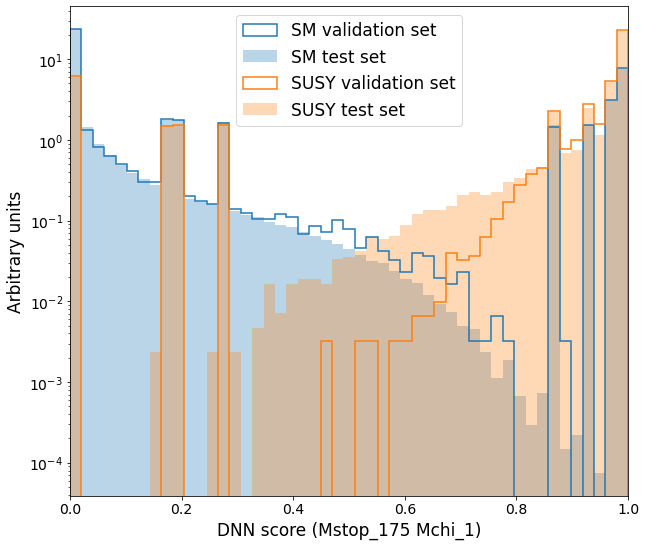

In [68]:
c0 = 'C0'
c1 = 'C1'
binning = np.linspace(0,1,50)
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_val[val_label == 0]  , bins=binning, label='SM validation set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[test_label == 0], bins=binning, label='SM test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_val[val_label == 1]  , bins=binning, label='SUSY validation set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[test_label == 1], bins=binning, label='SUSY test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
#plt.ylim(0.01, 20)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_175 Mchi_1)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)

/tmp/ipykernel_34353/95126346.py:31: RuntimeWarning: divide by zero encountered in true_divide
  ns3 / ns4,  # maybe check for div-by-zero!
/tmp/ipykernel_34353/95126346.py:31: RuntimeWarning: invalid value encountered in true_divide
  ns3 / ns4,  # maybe check for div-by-zero!


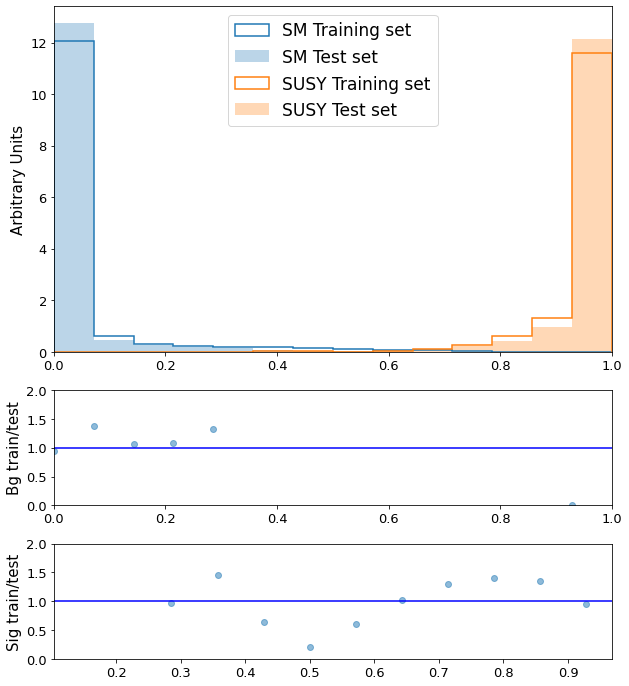

In [491]:
x_low    =  0
x_high   =  1

binning = np.linspace(x_low,x_high, 15)

ratio_fig_style = {
    'figsize': (10, 12),
    'gridspec_kw': {'height_ratios': (3, 1, 1)},
}

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, **ratio_fig_style)

ns1, bins1, patches  = ax1.hist(y_pred_train[label == 0], bins=binning, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
ns2, bins2, patches  = ax1.hist(y_pred_test[test_label == 0]  , bins=binning, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
ns3, bins3, patches  = ax1.hist(y_pred_train[label == 1], bins=binning, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
ns4, bins4, patches  = ax1.hist(y_pred_test[test_label == 1]  , bins=binning, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

ax1.legend(prop={'size': 17}, loc='upper center')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],  # this is what makes it comparable
               ns1 / ns2,  # maybe check for div-by-zero!
                alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Bg train/test' , fontsize=15)
#ax2.set_xlabel('ttbar mass (GeV)', fontsize=15)
ax2.set_ylim(0, 2)
ax2.set_xlim(x_low,x_high)

ax3.scatter(binning[:-1],  # this is what makes it comparable
               ns3 / ns4,  # maybe check for div-by-zero!
                alpha=0.5)

ax3.set_ylabel('Sig train/test', fontsize=15)
ax3.set_ylim(0, 2)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)
ax3.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
ax3.tick_params(axis="y", labelsize=13)

ax2.axhline(y=1, color='b', linestyle='-')
ax3.axhline(y=1, color='b', linestyle='-')
plt.show()

## FEATURE IMPORTANCES 

In [59]:
import eli5
from   eli5.sklearn import PermutationImportance

from keras.metrics import BinaryAccuracy
from eli5.permutation_importance import get_score_importances

def score(X, y):
    y_pred = model.predict(X).ravel()
    y_true = y.ravel()
    metric = BinaryAccuracy()
    metric.update_state(y_pred, y_true)
    return metric.result().numpy()

In [60]:
shuffler   = np.random.permutation(len(test_label))
test_data  = test_data[shuffler]
test_label = test_label[shuffler]

In [61]:
base_score, score_decreases = get_score_importances(score, test_data, test_label)
feature_importances         = np.mean(score_decreases, axis = 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [122]:
features = sig_df.columns
for i in range(len(feature_importances)) :
    print('Feature :: ' + str(features[i]) + ' importance :: ' + str(abs(feature_importances[i])))

Feature :: l_pt importance :: 0.0
Feature :: l_eta importance :: 0.111827634
Feature :: l_phi importance :: 0.0
Feature :: lbar_pt importance :: 0.0
Feature :: lbar_eta importance :: 0.11192025
Feature :: lbar_phi importance :: 0.0
Feature :: llbar_dphi importance :: 0.0
Feature :: llbar_deta importance :: 0.093535386
Feature :: MET importance :: 0.0
Feature :: MT2 importance :: 0.0


In [123]:
tt_region_1 = tt_df_test[tt_pred  < 0.5]
tt_region_2 = tt_df_test[tt_pred >= 0.5]

si_region_1 = sig_df_test[si_pred  < 0.5]
si_region_2 = sig_df_test[si_pred >= 0.5]

(array([0.06641743, 0.12142337, 0.21886978, 0.31554689, 0.36144928,
        0.35580765, 0.31336717, 0.21451034, 0.12385953, 0.07321303]),
 array([-2.31530508, -1.85329703, -1.39128898, -0.92928093, -0.46727288,
        -0.00526483,  0.45674322,  0.91875127,  1.38075932,  1.84276737,
         2.30477542]),
 [<matplotlib.patches.Polygon at 0x2a028b520>])

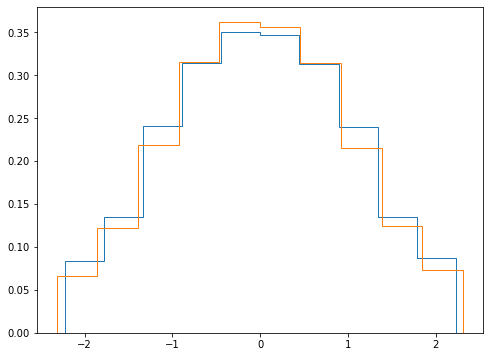

In [124]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(tt_region_1['l_eta'], histtype='step', density=True)
ax.hist(si_region_2['l_eta'], histtype='step', density=True)

(array([0.07014577, 0.12587626, 0.22909994, 0.31584902, 0.36051064,
        0.34609536, 0.31971026, 0.21262534, 0.11866862, 0.07413571]),
 array([-2.29402091, -1.83376767, -1.37351443, -0.9132612 , -0.45300796,
         0.00724528,  0.46749851,  0.92775175,  1.38800498,  1.84825822,
         2.30851146]),
 [<matplotlib.patches.Polygon at 0x2a646d7f0>])

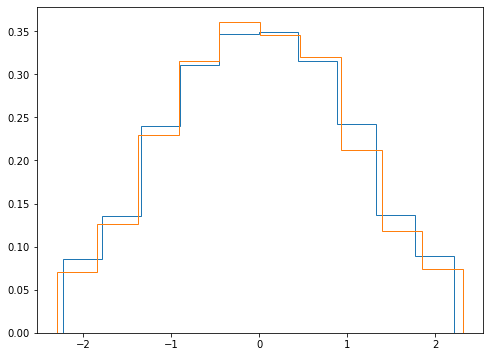

In [125]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(tt_region_1['lbar_eta'], histtype='step', density=True)
ax.hist(si_region_2['lbar_eta'], histtype='step', density=True)

(array([0.43666403, 0.39837181, 0.32605258, 0.21041766, 0.12994712,
        0.06028182, 0.02521221, 0.00919392, 0.00303305, 0.00085304]),
 array([-1.37172868, -0.74673932, -0.12174996,  0.50323941,  1.12822877,
         1.75321813,  2.37820749,  3.00319686,  3.62818622,  4.25317558,
         4.87816494]),
 [<matplotlib.patches.Polygon at 0x2a3939d90>])

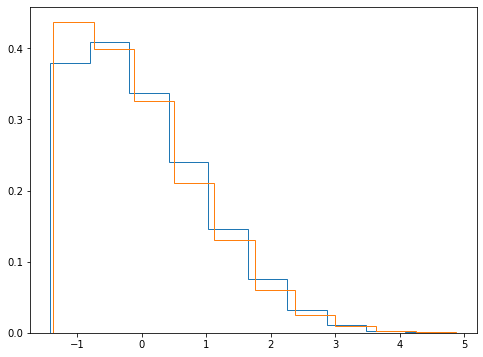

In [126]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(tt_region_1['llbar_deta'], histtype='step', density=True)
ax.hist(si_region_2['llbar_deta'], histtype='step', density=True)

## CHECK AN ALTERNATE MASS POINT

In [171]:
alt_df = pd.read_pickle('Pkl_files/Mstop_225_mchi_20.pkl')

In [134]:
alt_df_event_w   = alt_df['event_w']

In [135]:
selected_columns = ['l_pt', 'l_eta', 'l_phi', 'lbar_pt', 'lbar_eta', 'lbar_phi', 'llbar_dphi', 'llbar_deta', 'MET', 'MT2']
alt_df           = alt_df[selected_columns]

In [136]:
alt_df = (alt_df - alt_df.mean())/ alt_df.std()

In [137]:
alt_df

,l_pt,l_eta,l_phi,lbar_pt,lbar_eta,lbar_phi,llbar_dphi,llbar_deta,MET,MT2
0,-0.872444,0.669953,-1.371059,0.224592,0.255807,0.331776,1.390426,-0.767107,-0.859791,-1.127784
1,0.562003,-0.212628,-0.190048,0.989041,0.284933,1.464348,1.282158,-0.630288,-0.391176,-0.220253
2,-0.877728,-0.640022,-1.132422,0.040625,-0.020404,1.060193,0.423945,-0.450509,0.948513,1.122398
3,0.094075,-0.887821,1.449762,-0.626014,0.143811,-0.189065,1.217348,0.164941,-0.986548,-0.797643
4,-0.024119,1.058327,-1.176225,-0.775334,-0.221194,0.315624,0.944525,0.526504,-0.914549,-0.376631
...,...,...,...,...,...,...,...,...,...,...
50516,3.061002,0.811102,-0.653665,-0.522670,1.200649,0.623445,0.489009,-0.784744,0.370430,-0.367518
50517,-0.925540,0.598146,-1.539693,-0.874889,-0.041348,-0.945139,-0.945650,-0.428999,-1.210302,-0.093882
50518,-0.847393,0.062153,0.305437,-0.882211,1.300341,-1.646809,0.973598,0.481207,-0.248973,-0.321550
50519,0.387519,0.009777,-1.580816,-0.135915,0.308238,-0.616630,-0.166022,-0.926958,-0.666065,0.876156


In [138]:
alt_pred = model.predict(alt_df)

(array([7.17372353e+03, 0.00000000e+00, 1.27676651e+00, 3.34521383e+00,
        1.45373896e+03, 2.58447474e+00, 3.58403756e+00, 1.20728675e+01,
        5.45425001e+00, 1.66369886e+01, 1.33630759e+01, 1.49577215e+01,
        3.11597449e+01, 3.65674684e+01, 4.51607088e+01, 5.07081068e+01,
        6.76483463e+01, 9.21467218e+01, 9.30903895e+01, 1.10002706e+02,
        9.66340871e+01, 1.23704274e+02, 1.40024434e+02, 1.38771330e+02,
        1.60220301e+02, 1.49375153e+02, 1.84155052e+02, 1.88131968e+02,
        2.22019464e+02, 2.12164122e+02, 2.18284473e+02, 2.68240959e+02,
        3.35682818e+02, 2.74044141e+02, 3.46786346e+02, 3.47028020e+02,
        3.95188134e+02, 4.23198338e+02, 4.21787221e+02, 5.41056852e+02,
        5.85372319e+02, 7.49312532e+02, 7.91147615e+02, 1.10286199e+03,
        3.13621853e+03, 3.94372940e+03, 3.27263448e+03, 9.81308750e+03,
        8.59584546e+03]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714

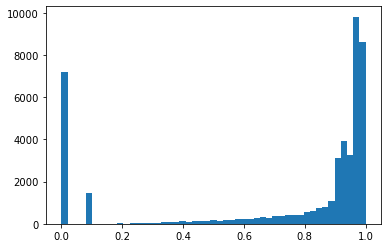

In [139]:
plt.hist(alt_pred, weights=alt_df_event_w, bins=binning)

In [172]:
sig_df = pd.read_pickle('Pkl_files_sc/Mstop_175_mchi_1.pkl')
tt_df  = pd.read_pickle('DESY_ttbar_sc.pkl')

In [173]:
#selected_columns = ['l_pt', 'l_eta', 'l_phi', 'lbar_pt', 'lbar_eta', 'lbar_phi', 'llbar_dphi', 'llbar_deta', 'MET', 'MT2']
selected_columns = ['llbar_dphi', 'llbar_deta','MET' ,'b1k', 'b2k', 'b1r', 'b2r', 'b1n', 'b2n']
sig_df = sig_df[selected_columns]
tt_df  = tt_df[selected_columns]

In [174]:
tt_df  = tt_df[:len(sig_df)] 

In [175]:
sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean  = tt_df.mean()
tt_std   = tt_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std

In [176]:
signal    = sig_df.values
bkg       = tt_df.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [180]:
def create_simple_network():
    model = Sequential()
    model.add(Dense(32,  input_dim = 9, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [181]:
from sklearn.model_selection import KFold

scores    = []
histories = []

for train, test in KFold(n_splits=4, shuffle=True).split(data,label):
    simple_model = create_simple_network() 
    histories.append(simple_model.fit(data[train], label[train], batch_size=32, epochs=50,verbose=1, shuffle=True,
                               validation_data = (data[test],label[test]), # feed in the test data for plotting
                               callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                               ModelCheckpoint(filepath='model.h5', verbose=0)]).history)
    
    scores.append(simple_model.evaluate(data[test], label[test], verbose = 0)) # evaluate the test dataset
    
print("average test loss: ", np.asarray(scores)[:,0].mean())
print("average test accuracy: ", np.asarray(scores)[:,1].mean())
print(simple_model.summary())

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 32)                320       
_________________________________________________________________
dropout_38 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing th

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2742/2850 [===========================>..] - ETA: 0s - loss: 0.4962 - accuracy: 0.7730WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14dd28ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

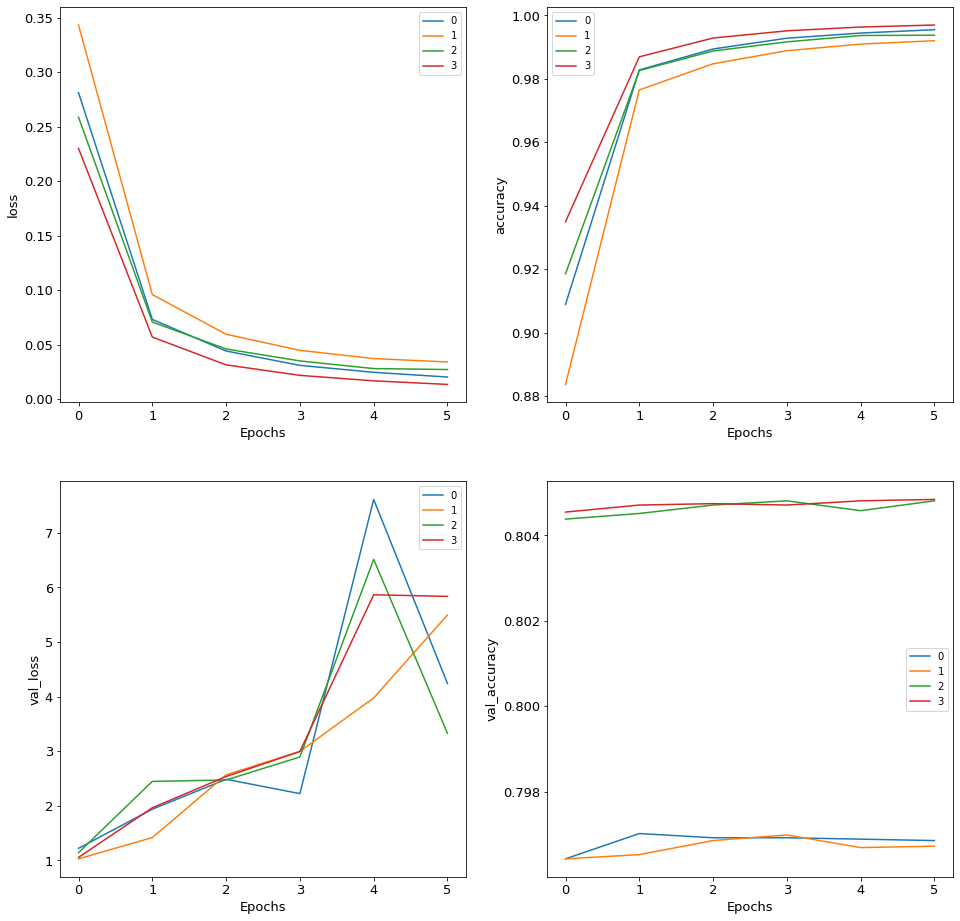

In [179]:
metrics = ['loss', 'accuracy','val_loss', 'val_accuracy']
fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (16,16))
axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
for i,metric in enumerate(metrics):
    for history in histories:
        axes[(i+2)//2 - 1, 1 - (i+1)%2].tick_params(axis="x", labelsize=13)
        axes[(i+2)//2 - 1, 1 - (i+1)%2].tick_params(axis="y", labelsize=13)
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_ylabel(metrics[i],fontsize=13)
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xlabel('Epochs'  ,fontsize=13)
        axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
        axes[(i+2)//2 - 1, 1 - (i+1)%2].legend([i for i in range(len(histories))])
        #axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(np.arange(max(history[metric])))